# Selective Capacitated Fair Pickup and Delivery Problem

In [1]:
from dataclasses import dataclass
import math
from random import random
from collections import deque
import csv
import time
import pandas as pd
import os, glob
from tqdm import tqdm



import matplotlib.pyplot as plt
import random
random.seed(1090)

## Defining an "Instance" class
we start by defining a "Instance" class that contains all the information we are given from an instance file. We can access the variables for each instance as attributes of our "Instance" class. This is the data strucutre our algorithms will act upon

In [90]:
@dataclass
class Instance:
    def __init__(self, filename: str | None = None):
        if filename is not None:
            self.load_from_file(filename)

    @staticmethod # tell python this method doesn't depend on "self"
    def read_tuple(f):
        return tuple(map(int, f.readline().split()))

    def load_from_file(self, filename):
        with open(filename) as input_file:
            params_line = input_file.readline().split(" ")
            self.n = int(params_line[0])
            self.n_k = int(params_line[1])
            self.C = int(params_line[2])
            self.gamma = int(params_line[3])
            self.rho = float(params_line[4])
            _ = input_file.readline()
            demand_line = [int(c_i) for c_i in input_file.readline().split()]
            _ = input_file.readline()
            self.depot = self.read_tuple(input_file)
            self.requests = []
            self.requests_location_array = []
            for i in range(self.n):
                pick_up = self.read_tuple(input_file)
                request = {
                    "pick_up": pick_up,
                    "drop_off": None,
                    "demand": demand_line[i],
                    "index": i + 1 # because they start with one (not zero) in the assignment
                }
                self.requests.append(request)
                self.requests_location_array.append(pick_up)
            for i in range(self.n):
                drop_off = self.read_tuple(input_file)
                self.requests[i]["drop_off"] = drop_off
                self.requests_location_array.append(drop_off)
            if input_file.readline().strip() != "":# make sure we are at the end of the file and there's no more content
                raise ValueError("Unexpected extra content at end of file")

In [91]:
# testing how the class works
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
aaa = Instance()
aaa.load_from_file(filename)
aaa.depot

(50, 50)

## Helper Functions for evaluating the performance of our algorithm

In [92]:
# takes two tuples representing carthesian coordinates as input
def a(u, v):
    return math.ceil(math.sqrt((u[0] - v[0])**2 + (u[1] - v[1])**2))

# takes the route as list of indices of request locations as input
def get_total_distance(instance, route):
    total_distance = 0
    current_location = instance.depot # we start at the depot
    for location_index in route:
        location_index = location_index - 1 # be careful with off-by-one errors!
        next_location = instance.requests_location_array[location_index]
        total_distance = total_distance + a(current_location, next_location)
        current_location = next_location
    total_distance = total_distance + a(current_location, instance.depot)
    return total_distance

# take a list of routes as input
def get_Jain_fairness(instance, routes):
    numerator = 0
    denominator = 0
    for route in routes:
        d = get_total_distance(instance, route)
        numerator = numerator + d
        denominator = denominator + d**2
    return numerator**2 / (instance.n_k * denominator) # I know it says n in the assignment but n_k makes more sense and its like that on wikipedia

def objective_function(instance, routes):
    value = 0
    for route in routes:
        value = value + get_total_distance(instance, route)
    value = value + instance.rho * (1 - get_Jain_fairness(instance, routes))
    return value

def delta_objective(instance, old_routes, new_routes):
    """
    Compute Δf = f(new_routes) - f(old_routes) in O(k) time,
    where k is the number of routes that changed (normally 1 or 2).
    """
    # --- 1. Identify changed routes ---
    changed = []
    for i, (r_old, r_new) in enumerate(zip(old_routes, new_routes)):
        if r_old != r_new:
            changed.append(i)

    # --- 2. Compute old and new distances only for changed routes ---
    d_old = []
    d_new = []
    for i in changed:
        d_old.append(get_total_distance(instance, old_routes[i]))
        d_new.append(get_total_distance(instance, new_routes[i]))

    # --- 3. Compute Δ total distance ---
    delta_dist = sum(d_new) - sum(d_old)

    # --- 4. Compute Jain fairness terms ---
    # Old aggregated sums
    old_all_dist = []
    for r in old_routes:
        old_all_dist.append(get_total_distance(instance, r))
    old_sum = sum(old_all_dist)
    old_sum_sq = sum(d * d for d in old_all_dist)

    # New aggregated sums (update only the changed routes)
    new_all_dist = old_all_dist.copy()
    for i, idx in enumerate(changed):
        new_all_dist[idx] = d_new[i]    # replace old distance with new

    new_sum = sum(new_all_dist)
    new_sum_sq = sum(d * d for d in new_all_dist)

    fairness_old = (old_sum * old_sum) / (instance.n_k * old_sum_sq)
    fairness_new = (new_sum * new_sum) / (instance.n_k * new_sum_sq)

    delta_fairness = instance.rho * ((1 - fairness_new) - (1 - fairness_old))

    # --- 5. Full delta ---
    return delta_dist + delta_fairness

From the assignment:

> A feasible solution consists of a route Rk for each vehicle k ∈ K, defined as an ordered sequence of
> pickup and drop-off locations with the i-th stop of a route being Rk,i. Each route must fulfill the
> following properties:
>
> • The vehicle capacity must never be exceeded at any point along the route.
>
> • Each served request must be handled in its entirety by a single vehicle.
>
> • At least γ requests must be served across all vehicles.

We create the following function to check this:

In [93]:
# does not work
def is_legal_route(instance, routes):
   pass

## Naive approach
Let's try a naive approach first to understand the problem format and to set a baseline we can compare against later. What's the simplest approach we can solve this problem with?
* every vehicle just drives from the depot to the resuest pick up location, then to the request drop off location, serve n/2 requests and then go back to the depot
* each vehicle serves n/n_k requests
* save route as list of int indices in an array

if index 1 is the pick up location, index 1 + n is the drop of location
So a naive route with n=10 & n_k = 2 would look like this

1 11 2 12 3 13 4 14 5 15

6 16 7 17 8 18 9 19 10 20

In [94]:
def naive_algorithm(instance):
    routes = []
    i = 1
    for k in range(instance.n_k):
        R_k = []
        request_to_serve = math.ceil(instance.n/instance.n_k)
        for request in range(request_to_serve):
            if i <= 2*instance.n:
                R_k.append(i)
                R_k.append(i + instance.n)
            else:
                print("Already all requests served")
            i = i + 1
        routes.append(R_k)
    return routes

In [95]:
filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
instance = Instance(filename)
routes = naive_algorithm(instance)

In [96]:
get_total_distance(instance, routes[0])

5630

In [97]:
get_Jain_fairness(instance, routes)

0.9994762106047755

In [98]:
objective_function(instance, routes)

11008.016530793313

## Visualization
In order to get a better feeling what our algorithm is actually doing, here is a small visualization (Code generated with ChatGPT)

In [99]:
def plot_routes(instance, routes):
    plt.figure(figsize=(10, 10))
    plt.scatter(*instance.depot, c="black", marker="s", s=100, label="Depot")  # draw the depot

    # Draw each vehicle's route
    for i, route in enumerate(routes):
        color = f"C{i % 10}"  # use matplotlib color cycle
        x_coords = [instance.depot[0]]
        y_coords = [instance.depot[1]]

        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            x_coords.append(loc[0])
            y_coords.append(loc[1])

        x_coords.append(instance.depot[0])
        y_coords.append(instance.depot[1])

        plt.plot(x_coords, y_coords, "-", color=color, label=f"Vehicle {i+1}")

        # Mark pickups (▲) and drop-offs (▼)
        for idx in route:
            loc = instance.requests_location_array[idx - 1]
            if idx <= instance.n:  # pickup
                plt.scatter(loc[0], loc[1], marker="^", color=color, s=70)
            else:  # drop-off
                plt.scatter(loc[0], loc[1], marker="v", color=color, s=70)

    # Compute metrics
    total_distance = sum(get_total_distance(instance, route) for route in routes)
    jain_score = get_Jain_fairness(instance, routes)
    obj_value = objective_function(instance, routes)

    # Add metrics to the plot
    plt.figtext(0.5, -0.01,  # x=0.5 centers it, y=-0.02 slightly below the plot
                f"Total Distance: {total_distance:.2f}    "
                f"Jain Fairness: {jain_score:.3f}    "
                f"Objective: {obj_value:.2f}",
                ha="center", fontsize=12)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.axis("equal")
    plt.show()

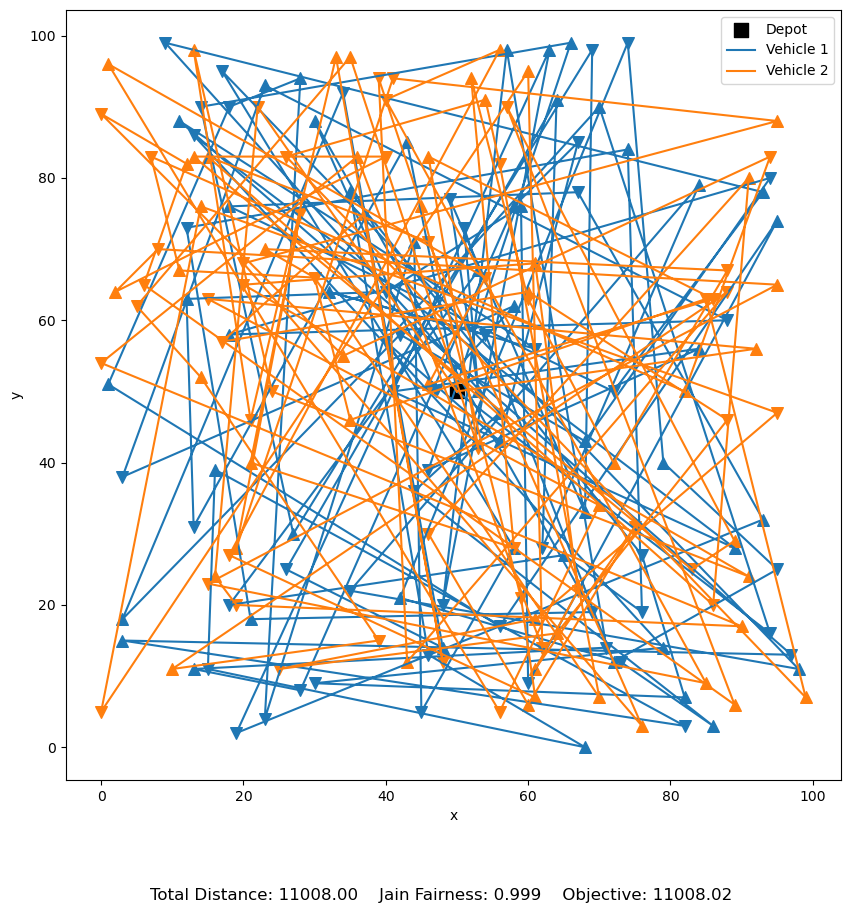

In [100]:
plot_routes(instance, routes)

## Subtask 1: Deterministic construction heuristic
For our first real subtask, we are asked to develop a meaningful construction heuristic. We chose to do so based on the Nearest Neighbor Heuristic, which means we start at an arbitrary node and always go to a nearest unvisited node. This seems like a reasonable choice.
We have to adapt this heuristic a little bit to match our specific problem, i.e. we have to take into account that we have multiple vehicles and we only need to satisfy gamma requests. So:
```
For each vehicle:
    - we look at the nearest pick up location
    - if we still have enough capacity, we go there and pick it up
    - if not, we go to the nearest drop of location
    - repeat until we have gamma requests done
```

<s>But apparently, this function still performs worse than the naive construction heuristic (in some cases)</s>

In [101]:
def nearest_neighbor_heuristic(instance):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]

    n_served = 0
    while n_served < instance.gamma:
        for k in range(instance.n_k):
            if not open_requests and not current_vehicle_requests[k]:
                continue #we skip this vehicle
            #print(f"lenopenreq: {len(open_requests)}")
            nearest_pick_up_location = None
            if open_requests:
                try:
                    nearest_pick_up_location = min(open_requests, key=lambda req: a(req["pick_up"], current_vehicle_location[k]))
                except ValueError: # we just don't have any open requests anymore
                    #print("no more open requests")
                    pass
            if nearest_pick_up_location is not None and (nearest_pick_up_location["demand"] + current_vehicle_capacity[k] <= instance.C):
                #print(f"PICKING UP: {nearest_pick_up_location}")
                #print(nearest_pick_up_location["demand"] + current_vehicle_capacity[k])
                current_vehicle_location[k] = nearest_pick_up_location["pick_up"] # we are driving to the new pick up location
                routes[k].append(nearest_pick_up_location["index"]) # write it down in our route list
                current_vehicle_requests[k].append(nearest_pick_up_location) # take the request
                current_vehicle_capacity[k] += nearest_pick_up_location["demand"] # use some loading capacity
                open_requests.remove(nearest_pick_up_location) # it's not an open request anymore
            elif current_vehicle_requests[k]:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                #print(f"DROPPING OFF: {nearest_drop_off_location}")
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
            else:
                print("some other case occured")
    # drop off the loaded requests:
    while any(current_vehicle_requests):
        for k in range(instance.n_k):
            if current_vehicle_requests[k]:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
    return routes

In [102]:
filename = "instances/100/competition/instance61_nreq100_nveh2_gamma91.txt"
instance = Instance(filename)
routes = nearest_neighbor_heuristic(instance)

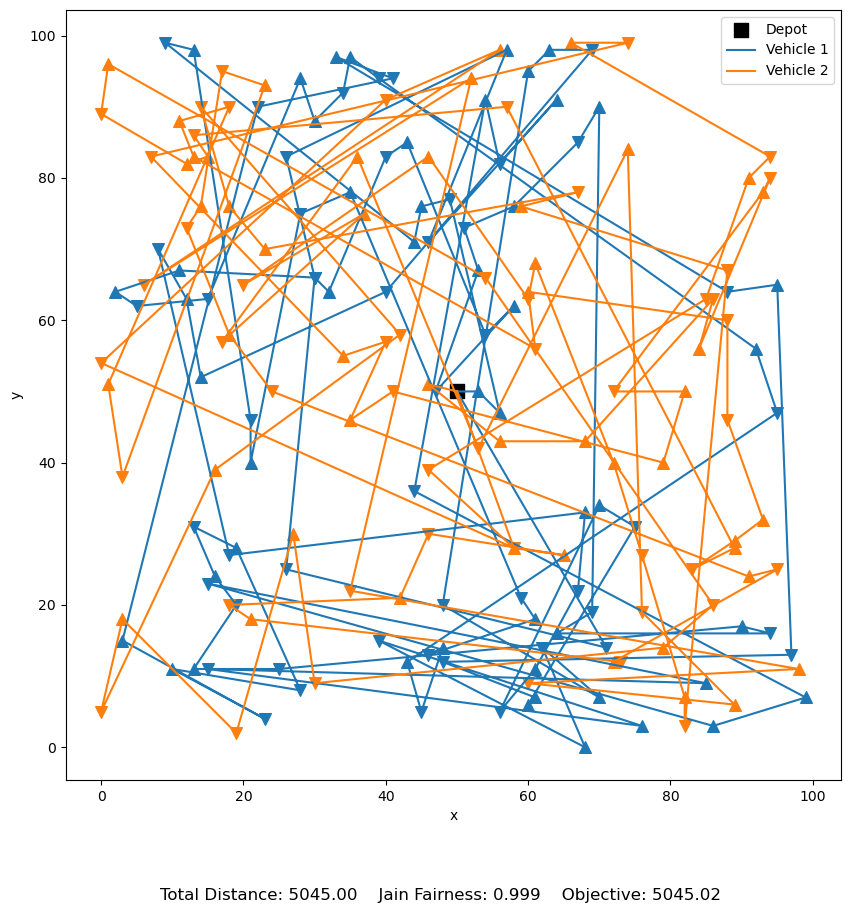

In [103]:
plot_routes(instance, routes)

## Subtask 2: Deriving a randomized construction heuristic
to be applied iteratively, yielding diverse promising results. For that we are going to take our Nearest Neighbor Heuristic, but modify it so that the vehicles decide randomly to pick up (if they can) or drop of (if they can). We should probably include a parameter that controls the bias towards one or the other. This is the "bias" parameter:
* if it is set to 0, the vehicle will always try to pick up more stuff if possible
* if it is set to 1, the vehicle will always try to drop off more stuff if possible

In [22]:
def randomized_nearest_neighbor_heuristic(instance, bias):
    open_requests = instance.requests.copy()
    routes = [[] for _ in range(instance.n_k)]
    current_vehicle_location = [instance.depot for _ in range(instance.n_k)]
    current_vehicle_capacity = [0 for _ in range(instance.n_k)]
    current_vehicle_requests = [[] for _ in range(instance.n_k)]
    n_served = 0
    while n_served < instance.gamma:
        for k in range(instance.n_k):
            random_number = random.random()
            if not open_requests and not current_vehicle_requests[k]:
                continue
            #print(f"lenopenreq: {len(open_requests)}")

            try:
                nearest_pick_up_location = min(open_requests, key=lambda req: a(req["pick_up"], current_vehicle_location[k]))
            except ValueError: # we just don't have any open requests anyomore
                pass
                #print("no more open requests")
            if ((bias <= random_number or (len(current_vehicle_requests[k]) == 0)) and
                    len(open_requests) != 0 and
                    (nearest_pick_up_location["demand"] + current_vehicle_capacity[k] <= instance.C)):
                #print(f"PICKING UP: {nearest_pick_up_location}")
                #print(nearest_pick_up_location["demand"] + current_vehicle_capacity[k])
                current_vehicle_location[k] = nearest_pick_up_location["pick_up"] # we are driving to the new pick up location
                routes[k].append(nearest_pick_up_location["index"]) # write it down in our route list
                current_vehicle_requests[k].append(nearest_pick_up_location) # take the request
                current_vehicle_capacity[k] += nearest_pick_up_location["demand"] # use some loading capacity
                open_requests.remove(nearest_pick_up_location) # it's not an open request anymore
            else:
                nearest_drop_off_location = min(current_vehicle_requests[k], key=lambda req: a(req["drop_off"], current_vehicle_location[k]))
                #print(f"DROPPING OFF: {nearest_drop_off_location}")
                current_vehicle_location[k] = nearest_drop_off_location["drop_off"] # driving to the drop off location
                routes[k].append(nearest_drop_off_location["index"] + instance.n) # writing down the location index in our route
                current_vehicle_requests[k].remove(nearest_drop_off_location) # not our request anymore
                current_vehicle_capacity[k] -= nearest_drop_off_location["demand"] # freeing some loading capacity
                n_served += 1 # we have succesfully completed one request!
    return routes

In [23]:
filename = "instances/50/test/instance31_nreq50_nveh2_gamma50.txt"
instance = Instance(filename)
routes = randomized_nearest_neighbor_heuristic(instance, 0.5)

In [24]:
objective_function(instance, routes)

4310.022150600883

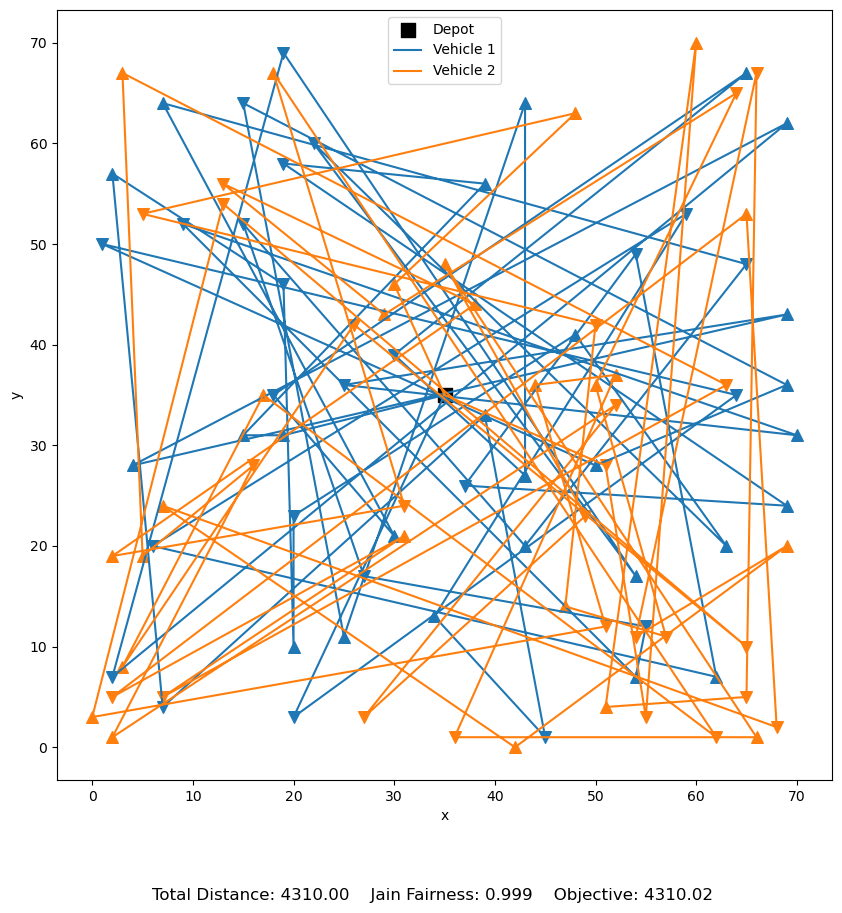

In [25]:
plot_routes(instance, routes)

## Subtask 3: Pilot / Beam Search

In this subtask, we are asked to develop either a Beam Search or a Pilot Search algorithm to hopefully improve our performance.
At first glance, Pilot Search appears attractive because it provides a more accurate evaluation of each decision by performing a complete greedy rollout for every candidate move:

| Aspect | **Beam Search** | **Pilot Search** |
|--------|------------------|------------------|
| **Core Idea** | Keep the β most promising partial solutions at each level | Evaluate each extension by completing it with a greedy rollout |
| **Evaluation Method** | Objective function on partial solutions | Full greedy completion from each extension |
| **Nodes Explored** | O(β·n) | O(n²) |
| **Computational Cost** | Lower (only evaluates partial solutions) | Higher (requires full greedy completion per extension) |
| **Look-Ahead** | Limited to the current level | Dynamic via simulated completions |
| **Accuracy** | Depends on objective quality | Generally higher (accounts for downstream effects) |

However, we encountered a structural issue in our previous algorithm design:
our heuristics optimized the vehicle routes in a round-robin fashion, meaning all vehicles were advanced simultaneously.
As a result, if the optimal behavior was something like
> “Vehicle 1 picks up request 5 and then immediately request 7 because it’s nearby,”
this was not possible — the algorithm would switch to vehicle 2 right after assigning a single request to vehicle 1.

To enable independent optimization of each vehicle’s route, we propose defining the node set as:

$$
(\text{set of all vehicles}) \times ((\text{open and feasible pickups}) \cup (\text{current requests for drop-off}))
$$

However, the nearest-neighbor heuristic we used earlier is not suitable for such independent vehicle optimization.
It also ignores the fairness objective, making it unreliable as a rollout policy for a Pilot Search.

**Therefore, we decided to implement a Beam Search approach**,
which evaluates partial global solutions directly and naturally supports both multi-vehicle coordination and the fairness objective.
In order to build the search tree, we also define a "Node" class, that represents a node in this search tree.

In [26]:
# creating an own class to represent the nodes
@dataclass
class Node:
    routes: list           # list[list[int]]
    loc: list              # current location per vehicle
    capacity: list              # current used capacity
    onboard: list          # onboard[k] = list of requests
    open_reqs: list        # list of remaining requests
    n_served: int
    score: float           # evaluation score

    def copy(self):
        """Create a deep copy of the state, but without copying the underlying request dicts."""
        return Node(
            routes=[r.copy() for r in self.routes],
            loc=self.loc.copy(),
            capacity=self.capacity.copy(),
            onboard=[lst.copy() for lst in self.onboard],
            open_reqs=self.open_reqs.copy(),
            n_served=self.n_served,
            score=self.score
        )

In [27]:
# create the children nodes
def expand_state(instance, node):
    if node.open_reqs == [] and all(len(o)==0 for o in node.onboard):
        print("No possible moves in this state, served: ", node.n_served)
    successors = []
    for k in range(instance.n_k):
        # Pick up successors
        for req in node.open_reqs:
            if node.capacity[k] + req["demand"] <= instance.C:
                S2 = node.copy()
                old_loc = S2. loc[k] # move old vehicle
                new_loc = req["pick_up"]
                S2.loc[k] = new_loc
                S2.routes[k].append(req["index"])
                S2.onboard[k].append(req)
                S2.open_reqs.remove(req)
                S2.capacity[k] += req["demand"]
                S2.score  = objective_function(instance, S2.routes)
                successors.append(S2)
        # Drop off successors
        for req in node.onboard[k]:
            S2 = node.copy()
            old_loc = S2.loc[k]
            new_loc = req["drop_off"]
            S2.loc[k] = new_loc
            S2.routes[k].append(req["index"] + instance.n)
            S2.onboard[k].remove(req)
            S2.capacity[k] -= req["demand"]
            S2.score = objective_function(instance, S2.routes)
            S2.n_served += 1
            successors.append(S2)
    return successors

In [28]:
def beam_search(instance, beta):
    init = Node(
        routes = [[] for _ in range(instance.n_k)],
        loc = [instance.depot for _ in range(instance.n_k)],
        capacity = [0 for _ in range(instance.n_k)],
        onboard=[[] for _ in range(instance.n_k)],
        open_reqs=instance.requests.copy(),
        n_served=0,
        score=0.0
    )
    beam = [init]
    while True:
        if all(s.n_served >= instance.gamma for s in beam):
            out = min(successors, key=lambda s: s.score)
            print(out)
            return out.routes
        successors = []
        for s in beam:
            successors.extend(expand_state(instance, s))

        successors.sort(key=lambda s: s.score)
        beam = successors[:beta]

In [29]:
routes = beam_search(instance, 100)
objective_function(instance, routes)

Node(routes=[[5, 17, 30, 19, 80, 0, 50, 3, 67, 55, 36, 86, 53, 38, 69, 34, 88, 39, 84, 89, 15, 25, 27, 65, 77, 75], [10, 9, 11, 29, 79, 60, 59, 13, 63, 31, 16, 28, 81, 78, 4, 61, 35, 54, 66, 8, 58, 18, 68, 21, 12, 62, 2, 44, 94, 42, 92, 71, 22, 72, 33, 24, 74, 1, 83, 23, 73, 85, 32, 52, 26, 76, 82, 43, 14, 64, 7, 51, 37, 57, 45, 95, 46, 96, 87, 20, 6, 47, 70, 48, 56, 49, 99, 97, 41, 98, 40, 93, 91, 90]], loc=[(13, 54), (51, 12)], capacity=[0, 0], onboard=[[], []], open_reqs=[], n_served=50, score=1813.0821057021053)


1813.0821057021053

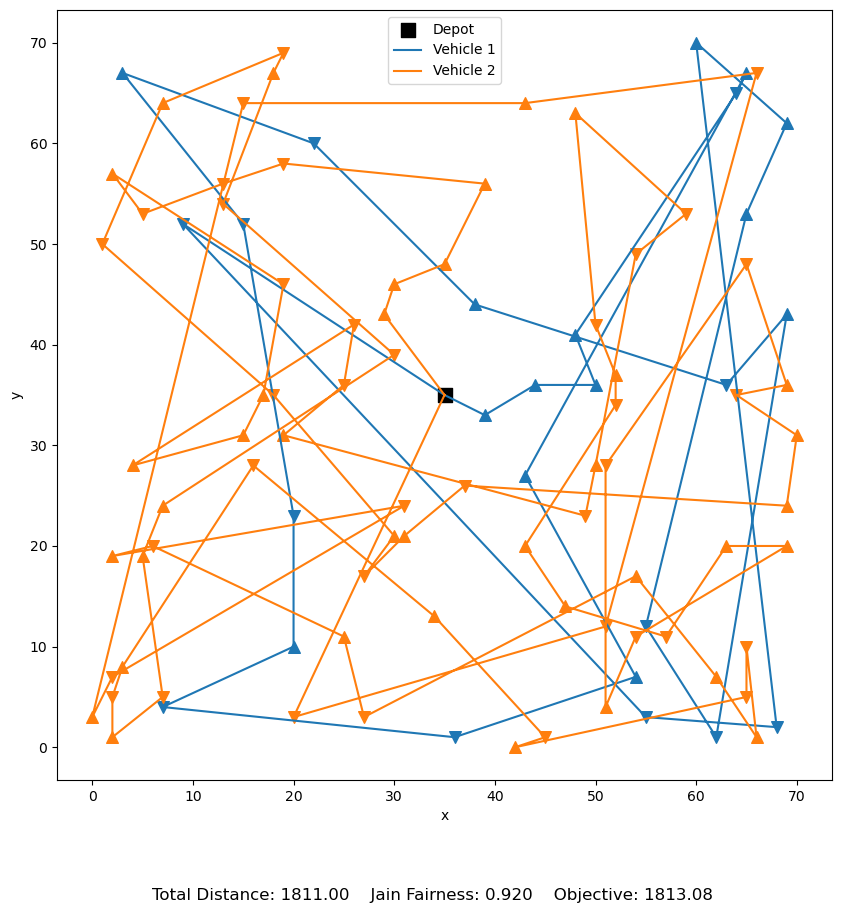

In [30]:
plot_routes(instance, routes)

## Subtask 4: Developing a framework for basic local search
which is able to deal with **different neighborhood structures** and different **step functions**
We descided to implement the following three neighborhood structures:

1.) A simple request relocation:
    We take a request from Veicle A and move it to vehicle B. Vehicle B drops the resuest of immedeatly after pick up

2.) flexible request relocation:
    We take a request from Veicle A and move it to vehicle B. We try to drop it off not immedeatly, but at a later, feasible time

3.) SwapNeighborhood:
    Swap a request of Vehicle A with a request of vehicle B.

Furthermore, we have to create a new State class, that only conists of the data we need.

In [31]:
@dataclass(frozen=True)
class State:
    routes: tuple[tuple[int]]
    served: frozenset
    unserved: frozenset
    score: float

    @staticmethod
    def from_routes(instance, routes):
        """Build State from raw routes (list of lists)."""
        served = set()
        for vroute in routes:
            for idx in vroute:
                if idx < instance.n:
                    served.add(idx)
        served = frozenset(served)
        unserved = frozenset(set(range(instance.n)) - served)
        score = objective_function(instance, routes)
        return State(
            routes=tuple(tuple(r) for r in routes),
            served=served,
            unserved=unserved,
            score=score
        )

In [32]:
# Some utility functions
def remove_request_from_route(route, req_idx, n):
    """Remove both pickup(req_idx) and dropoff(req_idx+n)."""
    new_route = [x for x in route if x != req_idx and x != req_idx+n]
    return new_route


def insert_request_compact(route, req_idx, n):
    """Insert pickup and then dropoff immediately after."""
    new_route = route.copy()
    # insert pickup at all possible positions
    for pos in range(len(route)+1):
        tmp = new_route[:pos] + [req_idx, req_idx + n] + new_route[pos:]
        yield tmp


def insert_request_flexible(route, req_idx, n):
    """Try all pickup and dropoff insertion positions (pickup_pos < dropoff_pos)."""
    L = len(route)
    for p in range(L+1):            # pickup position
        for d in range(p+1, L+2):   # dropoff position after pickup
            new_r = route[:p] + [req_idx] + route[p:d] + [req_idx+n] + route[d:]
            yield new_r


def capacity_feasible(instance, route):
    """Check capacity along route."""
    load = 0
    for idx in route:
        if idx < instance.n:    # pickup
            load += instance.requests[idx]["demand"]
            if load > instance.C:
                return False
        else:                   # dropoff
            real = idx - instance.n
            load -= instance.requests[real]["demand"]
            if load < 0:
                return False
    return True

In [33]:
class RelocateCompact:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        for v_from, route_from in enumerate(routes):
            for idx in route_from:
                if idx >= self.n:
                    continue     # dropoff, skip
                req_idx = idx
                # Try removing from one vehicle, inserting in another
                for v_to in range(len(routes)):
                    if v_to == v_from:
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_compact(routes[v_to], req_idx, self.n):
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from):
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            yield State.from_routes(self.instance, new_routes)


# takin request from one vehicle to another vehicle
class RelocateFlexible:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes] # converting to list
        for v_from, route_from in enumerate(routes): # vehicle and route
            for idx in route_from:
                if idx >= self.n: # it's a drop-off index
                    continue
                req_idx = idx # it's a pick up index
                for v_to in range(len(routes)): # iterating over all other possible vehicles
                    if v_to == v_from: # we obviously don't want to move to our own vehicle again
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_flexible(routes[v_to], req_idx, self.n): # iterating over all
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from): # feasible drop-off locations
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            yield State.from_routes(self.instance, new_routes)

# special version, later used for Simulated Annealing
class RelocateRandomly:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state:State):
        routes = [list(r) for r in state.routes] # converting to list
        vehicles_with_pickups = [i for i, r in enumerate(routes) if any(idx < self.n for idx in r)] # pick a random vehicle with at least one pickup
        if not vehicles_with_pickups:
            return  # no feasible move

        v_from = random.choice(vehicles_with_pickups)
        route_from = routes[v_from]

        # pick a random pickup in that vehicle
        pickup_indices = [idx for idx in route_from if idx < self.n]
        req_idx = random.choice(pickup_indices)

        # pick a random other vehicle to move to
        v_to_candidates = [i for i in range(len(routes)) if i != v_from]
        v_to = random.choice(v_to_candidates)
        route_to = routes[v_to]

        # remove request from original route
        r_from = remove_request_from_route(route_from, req_idx, self.n)

        # try inserting randomly into the target vehicle
        # try inserting randomly into the target vehicle, only keep feasible insertions
        feasible_insertions = [
            r for r in insert_request_flexible(route_to, req_idx, self.n)
            if capacity_feasible(self.instance, r)
        ]
        if not feasible_insertions:
            return  # no feasible insertion
        r_to = random.choice(feasible_insertions)

        # assemble new routes
        new_routes = []
        for k, r in enumerate(routes):
            if k == v_from:
                new_routes.append(r_from)
            elif k == v_to:
                new_routes.append(r_to)
            else:
                new_routes.append(r)

        # yield a single random neighbor
        yield State.from_routes(self.instance, new_routes)


class SwapRequests:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]

        # all pairs of vehicles
        for v1 in range(len(routes)):
            for v2 in range(v1+1, len(routes)):
                for idx1 in routes[v1]:
                    if idx1 >= self.n:
                        continue
                    for idx2 in routes[v2]:
                        if idx2 >= self.n:
                            continue

                        # remove both requests
                        r1_rem = remove_request_from_route(routes[v1], idx1, self.n)
                        r2_rem = remove_request_from_route(routes[v2], idx2, self.n)

                        # try inserting each into the other vehicle (compact insertion)
                        for r1_add in insert_request_compact(r1_rem, idx2, self.n):
                            for r2_add in insert_request_compact(r2_rem, idx1, self.n):
                                if capacity_feasible(self.instance, r1_add) and capacity_feasible(self.instance, r2_add):
                                    new_routes = []
                                    for k, r in enumerate(routes):
                                        if k == v1:
                                            new_routes.append(r1_add)
                                        elif k == v2:
                                            new_routes.append(r2_add)
                                        else:
                                            new_routes.append(r)
                                    yield State.from_routes(self.instance, new_routes)

In [34]:
# Here's the same code but with delta evaluation:
class RelocateCompact_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]
        for v_from, route_from in enumerate(routes):
            for idx in route_from:
                if idx >= self.n:
                    continue     # dropoff, skip
                req_idx = idx
                # Try removing from one vehicle, inserting in another
                for v_to in range(len(routes)):
                    if v_to == v_from:
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_compact(routes[v_to], req_idx, self.n):
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from):
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)

                            delta = delta_objective(
                                self.instance,
                                state.routes,                    # old state routes (tuple of tuples)
                                tuple(tuple(r) for r in new_routes)  # new routes in same format
                            )
                            new_score = state.score + delta
                            yield State(
                                routes=tuple(tuple(r) for r in new_routes),
                                served=state.served,      # you can recompute if needed
                                unserved=state.unserved,
                                score=new_score
                            )

class RelocateFlexible_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes] # converting to list
        for v_from, route_from in enumerate(routes): # vehicle and route
            for idx in route_from:
                if idx >= self.n: # it's a drop-off index
                    continue
                req_idx = idx # it's a pick up index
                for v_to in range(len(routes)): # iterating over all other possible vehicles
                    if v_to == v_from: # we obviously don't want to move to our own vehicle again
                        continue
                    r_from = remove_request_from_route(route_from, req_idx, self.n)
                    for r_to in insert_request_flexible(routes[v_to], req_idx, self.n): # iterating over all
                        if capacity_feasible(self.instance, r_to) and capacity_feasible(self.instance, r_from): # feasible drop-off locations
                            new_routes = []
                            for k, r in enumerate(routes):
                                if k == v_from:
                                    new_routes.append(r_from)
                                elif k == v_to:
                                    new_routes.append(r_to)
                                else:
                                    new_routes.append(r)
                            delta =  delta = delta_objective(
                                self.instance,
                                state.routes,                    # old state routes (tuple of tuples)
                                tuple(tuple(r) for r in new_routes)  # new routes in same format
                            )
                            new_score = state.score + delta
                            yield State(
                                routes=tuple(tuple(r) for r in new_routes),
                                served=state.served,      # you can recompute if needed
                                unserved=state.unserved,
                                score=new_score
                            )

# special version, later used for Simulated Annealing
class RelocateRandomly_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state:State):
        routes = [list(r) for r in state.routes] # converting to list
        vehicles_with_pickups = [i for i, r in enumerate(routes) if any(idx < self.n for idx in r)] # pick a random vehicle with at least one pickup
        if not vehicles_with_pickups:
            return  # no feasible move

        v_from = random.choice(vehicles_with_pickups)
        route_from = routes[v_from]

        # pick a random pickup in that vehicle
        pickup_indices = [idx for idx in route_from if idx < self.n]
        req_idx = random.choice(pickup_indices)

        # pick a random other vehicle to move to
        v_to_candidates = [i for i in range(len(routes)) if i != v_from]
        v_to = random.choice(v_to_candidates)
        route_to = routes[v_to]

        # remove request from original route
        r_from = remove_request_from_route(route_from, req_idx, self.n)

        # try inserting randomly into the target vehicle
        # try inserting randomly into the target vehicle, only keep feasible insertions
        feasible_insertions = [
            r for r in insert_request_flexible(route_to, req_idx, self.n)
            if capacity_feasible(self.instance, r)
        ]
        if not feasible_insertions:
            return  # no feasible insertion
        r_to = random.choice(feasible_insertions)

        # assemble new routes
        new_routes = []
        for k, r in enumerate(routes):
            if k == v_from:
                new_routes.append(r_from)
            elif k == v_to:
                new_routes.append(r_to)
            else:
                new_routes.append(r)

        # yield a single random neighbor
        delta =  delta = delta_objective(
                                self.instance,
                                state.routes,                    # old state routes (tuple of tuples)
                                tuple(tuple(r) for r in new_routes)  # new routes in same format
                            )
        new_score = state.score + delta
        yield State(
            routes=tuple(tuple(r) for r in new_routes),
            served=state.served,      # you can recompute if needed
            unserved=state.unserved,
            score=new_score
        )

class SwapRequests_delta:
    def __init__(self, instance):
        self.instance = instance
        self.n = instance.n

    def neighbors(self, state: State):
        routes = [list(r) for r in state.routes]

        # all pairs of vehicles
        for v1 in range(len(routes)):
            for v2 in range(v1+1, len(routes)):
                for idx1 in routes[v1]:
                    if idx1 >= self.n:
                        continue
                    for idx2 in routes[v2]:
                        if idx2 >= self.n:
                            continue

                        # remove both requests
                        r1_rem = remove_request_from_route(routes[v1], idx1, self.n)
                        r2_rem = remove_request_from_route(routes[v2], idx2, self.n)

                        # try inserting each into the other vehicle (compact insertion)
                        for r1_add in insert_request_compact(r1_rem, idx2, self.n):
                            for r2_add in insert_request_compact(r2_rem, idx1, self.n):
                                if capacity_feasible(self.instance, r1_add) and capacity_feasible(self.instance, r2_add):
                                    new_routes = []
                                    for k, r in enumerate(routes):
                                        if k == v1:
                                            new_routes.append(r1_add)
                                        elif k == v2:
                                            new_routes.append(r2_add)
                                        else:
                                            new_routes.append(r)
                                        delta = delta_objective(
                                            self.instance,
                                            state.routes,                    # old state routes (tuple of tuples)
                                            tuple(tuple(r) for r in new_routes)  # new routes in same format
                                        )
                                        new_score = state.score + delta
                                        yield State(
                                            routes=tuple(tuple(r) for r in new_routes),
                                            served=state.served,      # you can recompute if needed
                                            unserved=state.unserved,
                                            score=new_score
                                        )

We define the **first improevement** and **best imporvement** step functions

In [35]:
def first_improvement(state, neighborhood):
    for neigh in neighborhood.neighbors(state):
        if neigh.score < state.score:
            return neigh
    return state

def best_improvement(state, neighborhood):
    best = state
    for neigh in neighborhood.neighbors(state):
        if neigh.score < best.score:
            best = neigh
    return best

## Subtask 5: Develop at least three different meaningful neighborhood structures
Since we have already done that in the previous part, we are going to skip this.

## Subtask 6: Variable Neighborhood descent
Develop or make use of a Variable Neighborhood Descent (VND) framework which uses your
neighborhood structures. This method is a local search metaheuristic that uses a list of neighborhood structures instead of a single one.
Method takes advantage of the following observations:

1. A local optimum with respect to one neighborhood structure
is not necessarily a local optimum with respect to another.

2. A global optimum is a local optimum with respect to all possible neighborhood
structures.

3. For many problems good local optima are relatively close together.

In [36]:
def variable_neighborhood_descent(initial_state, neighborhoods, step_fn, max_iter=100):
    state = initial_state

    for it in range(max_iter):
        improved = False

        for N in neighborhoods:
            new_state = step_fn(state, N)
            if new_state.score < state.score:
                state = new_state
                #print("New Score: ", state.score)
                improved = True
                break

        if not improved:
            print(f"No more Improvements found after {it} iterations!")
            break

    return state

In [37]:
routes = nearest_neighbor_heuristic(instance)
initial = State.from_routes(instance, routes)

# defining a list of neighborhoods
neighborhoods = [
    RelocateCompact(instance),
    RelocateFlexible(instance),
    SwapRequests(instance)
]

local_optimum = variable_neighborhood_descent(
    initial,
    neighborhoods,
    step_fn=first_improvement,
    max_iter=100
)

print(local_optimum.score)

No more Improvements found after 43 iterations!
3216.97


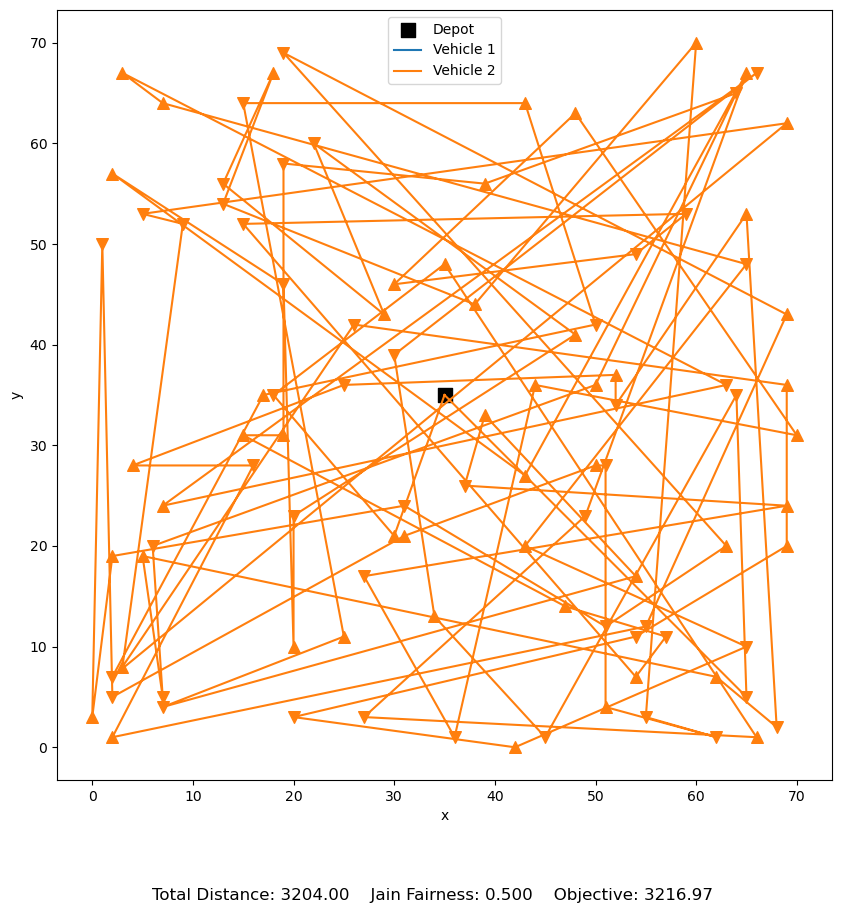

In [38]:
plot_routes(instance, local_optimum.routes)

## Subtask 7: GRASP (Greedy randomized Adaptive Search Procedure)
Now we are asked to implement GRASP using our randomized nearest neighbor construction heuristic from earlier, togehter with a step funciton
The algorithm works in two stages:

1.) greedy randomized construction

2.) Local search typically with best improvement

In [39]:
def runGRASP():
    solutions = []
    for i in range(10):
        random_bias = 1 - (0.1 * i)
        print(f"testing wiht bias {random_bias}")
        greedy_randomized = randomized_nearest_neighbor_heuristic(instance, random_bias)
        initial = State.from_routes(instance, greedy_randomized)
        neighborhoods = [
            RelocateCompact(instance),
            SwapRequests(instance),
            RelocateFlexible(instance),
        ]
        improvement = variable_neighborhood_descent(initial, neighborhoods, first_improvement, 200) # set to first improvement for speed, best improevemt for quality
        solutions.append(improvement)
        print(f"Imrovement score: {improvement.score}")

    best_solution = min(solutions, key=lambda s: s.score)
    return best_solution.routes

testing wiht bias 1.0
No more Improvements found after 33 iterations!
Imrovement score: 3333.97
testing wiht bias 0.9
No more Improvements found after 43 iterations!
Imrovement score: 3348.97
testing wiht bias 0.8
No more Improvements found after 31 iterations!
Imrovement score: 3045.97
testing wiht bias 0.7
No more Improvements found after 37 iterations!
Imrovement score: 3095.97
testing wiht bias 0.6
No more Improvements found after 35 iterations!
Imrovement score: 3194.97
testing wiht bias 0.5
No more Improvements found after 35 iterations!
Imrovement score: 3044.97
testing wiht bias 0.3999999999999999
No more Improvements found after 38 iterations!
Imrovement score: 3120.97
testing wiht bias 0.29999999999999993
No more Improvements found after 51 iterations!
Imrovement score: 3186.97
testing wiht bias 0.19999999999999996
No more Improvements found after 39 iterations!
Imrovement score: 3078.97
testing wiht bias 0.09999999999999998
No more Improvements found after 53 iterations!
Imr

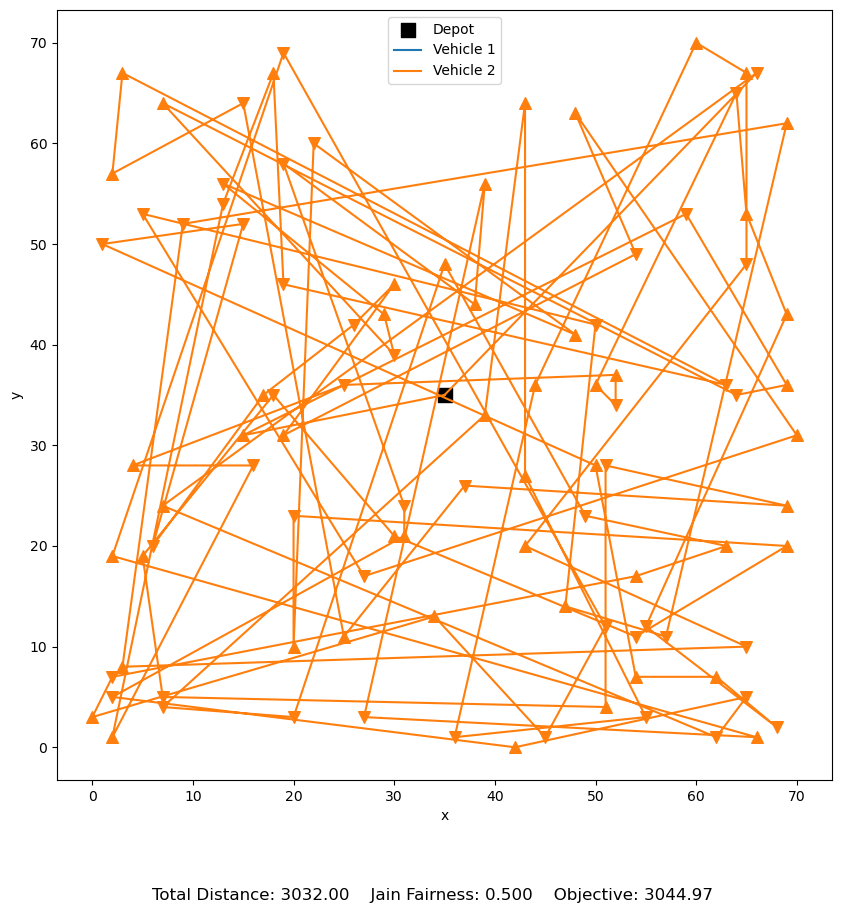

In [40]:
routes = runGRASP()
plot_routes(instance, routes)

## Subtask 8: implement one of the following metaheuristics ... : Simulated Annealing (SA)
We are going to choose Simulated Annealing because we like it. It will probably take some effort to fine-tune it in order to find the best parameters.

In [41]:
def simulated_annealing(instance, routes, T_init, alpha=0.95):
    x = State.from_routes(instance, routes)
    t = 0
    T = T_init
    last_improvements = deque(maxlen=1000)
    last_improvements.append(True)
    scores = []  # Collect scores in each 1000-iteration block

    while any(last_improvements) and T > 1:
        accepted_random_moves = 0
        block_scores = []  # Scores for this block
        while t < 1000:
            neighborhood = RelocateRandomly(instance)
            random_neighbour = next(neighborhood.neighbors(x))
            diff = abs(random_neighbour.score - x.score)
            if random_neighbour.score < x.score:
                x = random_neighbour
                last_improvements.append(True)
            else:
                if random.random() < math.exp(-abs(random_neighbour.score - x.score) / T):
                    x = random_neighbour
                    accepted_random_moves += 1
                last_improvements.append(False)
            block_scores.append(x.score)  # Record score after each move
            t += 1

        # Compute stats after 100 inner iterations
        best_score = min(block_scores)
        worst_score = max(block_scores)
        mean_score = sum(block_scores) / len(block_scores)
        print(f"Acceptance of random moves: {accepted_random_moves / 10} %, Temperature: {T}")
        print(f"Best score: {best_score:.4f}, Worst score: {worst_score:.4f}, Mean score: {mean_score:.4f}")
        T = alpha * T
        t = 0
    return x.routes

Acceptance of random moves: 3.7 %, Temperature: 10
Best score: 2265.3965, Worst score: 4121.0312, Mean score: 2632.7942
Acceptance of random moves: 1.7 %, Temperature: 9.0
Best score: 2069.4066, Worst score: 2297.6615, Mean score: 2173.7144
Acceptance of random moves: 1.4 %, Temperature: 8.1
Best score: 2002.3437, Worst score: 2134.0845, Mean score: 2073.9544
Acceptance of random moves: 1.7 %, Temperature: 7.29
Best score: 1972.2964, Worst score: 2070.0988, Mean score: 2019.5864
Acceptance of random moves: 1.0 %, Temperature: 6.561
Best score: 1930.1951, Worst score: 2008.1050, Mean score: 1981.9831
Acceptance of random moves: 0.7 %, Temperature: 5.9049000000000005
Best score: 1878.0184, Worst score: 1953.2209, Mean score: 1922.5505
Acceptance of random moves: 0.7 %, Temperature: 5.3144100000000005
Best score: 1891.1687, Worst score: 1933.6463, Mean score: 1909.9385
Acceptance of random moves: 0.3 %, Temperature: 4.7829690000000005
Best score: 1812.1369, Worst score: 1903.0012, Mean sc

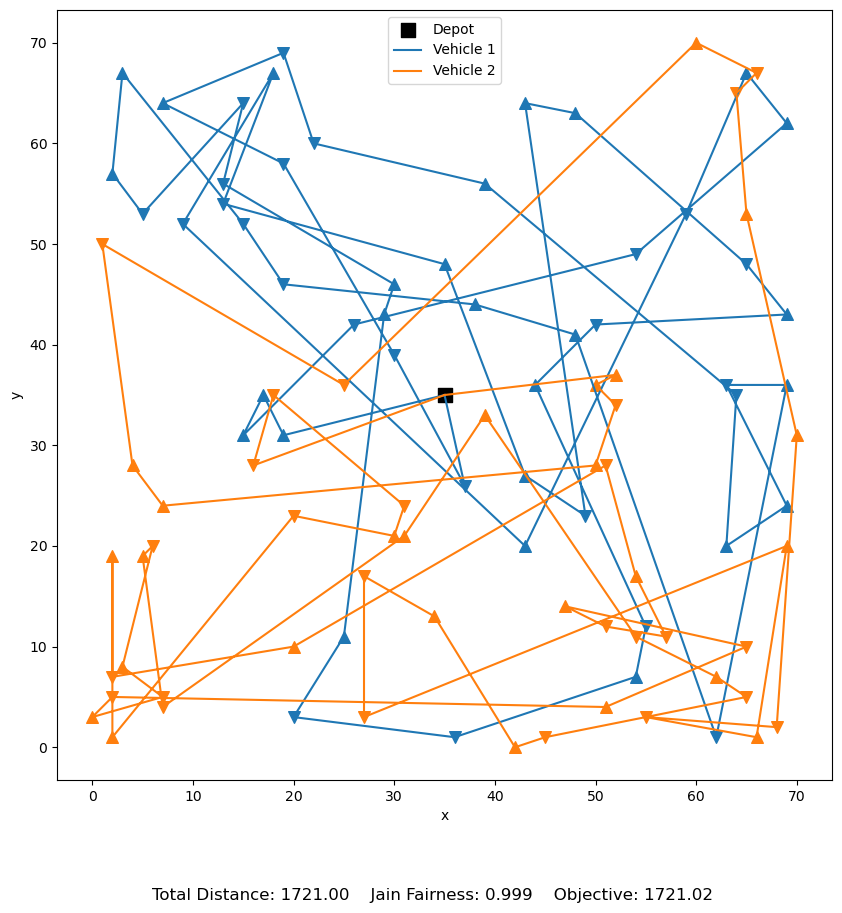

In [37]:
routes = nearest_neighbor_heuristic(instance)
routes = simulated_annealing(instance, routes, 10, alpha = 0.9)
plot_routes(instance, routes)

It's hard to choose the right parameters for SA
Idea for further imporvement: Create a neighborhood structure that

## Subtask 9: Use delta evaluation
Meaning: instead of recompiling an entire function, e.g. the objective function, we only compute the difference the change causes, and add/subtract this value. So let's start by designing a delta evaluated objective function. The delta objective function was moved up to the other delta evaluation, so that it is defined before it is called :)

However, from our (limited) testing experience, delta evaluation is not always faster.

Furthermore, we are asked: Is it possible to pre-process an instance and use derived information later more efficiently?
Anwser: Yes, by precomputing a distance matrix between all pickup, dropoff, and depot locations, as well as caching route distance sums and squared sums, we can later evaluate routes and delta-objectives more efficiently without recalculating distances repeatedly. However, since we want to focus on experimental tuning right now, we didn't implement this

## Subtask 10: Experimental manual tuning
Now we are asked to perform some experimental manual tuning of relevant algorithmic parameters to find sensible parameter settings for your final experiments. We mainly want to find the best hyperparamters for the Simulated Annealing, namely the initial Temperature T as well as the cooling Schedule variable alpha. For this, We suggest a grid search over the parameter range T = [5, 10, 15, 20, 25, 30] as well as alpha = [0.9, 0.95, 0.98, 0.99]. For each run of the algorithm, we save the time, the final score (objective function, as well as jain fairness).

In [40]:
# Parameter ranges
T_values = [5, 10, 15, 20, 25, 30]
alpha_values = [0.9, 0.95, 0.98, 0.99]


# Output CSV file
output_file = "sa_grid_search_results.csv"

# Prepare CSV header
with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["T_init", "alpha", "runtime_sec", "final_objective", "final_jain_fairness"])

# Grid search loop
for T_init in T_values:
    for alpha in alpha_values:
        print(f"Running SA with T_init={T_init}, alpha={alpha}")
        # Start timer
        start_time = time.time()

        # Run SA
        initial_routes = nearest_neighbor_heuristic(instance)
        final_routes = simulated_annealing(instance, initial_routes, T_init, alpha)

        # End timer
        end_time = time.time()
        runtime = end_time - start_time

        # Compute final scores
        final_obj = objective_function(instance, final_routes)
        final_jain = get_Jain_fairness(instance, final_routes)

        # Save to CSV
        with open(output_file, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([T_init, alpha, runtime, final_obj, final_jain])

        print(f"Done: runtime={runtime:.2f}s, objective={final_obj:.4f}, Jain={final_jain:.4f}\n")

Running SA with T_init=5, alpha=0.9
Acceptance of random moves: 2.4 %, Temperature: 5
Best score: 2230.8971, Worst score: 4094.0286, Mean score: 2622.4740
Acceptance of random moves: 0.8 %, Temperature: 4.5
Best score: 2047.4533, Worst score: 2249.5752, Mean score: 2109.7267
Acceptance of random moves: 0.1 %, Temperature: 4.05
Best score: 2022.4544, Worst score: 2047.4533, Mean score: 2033.3634
Acceptance of random moves: 0.4 %, Temperature: 3.645
Best score: 1985.1780, Worst score: 2037.7563, Mean score: 2009.3210
Acceptance of random moves: 0.3 %, Temperature: 3.2805
Best score: 1922.0117, Worst score: 1985.1780, Mean score: 1948.9736
Acceptance of random moves: 0.1 %, Temperature: 2.9524500000000002
Best score: 1892.3974, Worst score: 1922.0117, Mean score: 1909.1751
Acceptance of random moves: 0.2 %, Temperature: 2.6572050000000003
Best score: 1892.3974, Worst score: 1893.3364, Mean score: 1892.7940
Acceptance of random moves: 0.2 %, Temperature: 2.3914845000000002
Best score: 1818

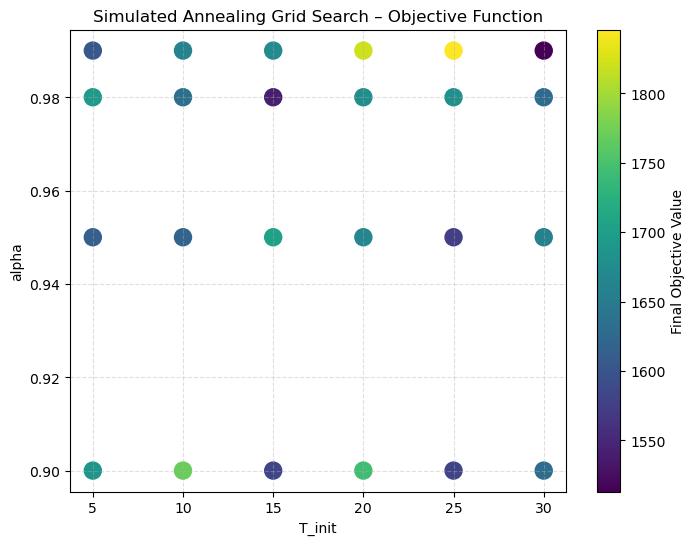

In [42]:
# Load CSV
df = pd.read_csv("sa_grid_search_results.csv")

# Plot objective function as scatter over the grid
plt.figure(figsize=(8, 6))
plt.scatter(df["T_init"], df["alpha"], s=150, c=df["final_objective"])
plt.colorbar(label="Final Objective Value")

plt.xlabel("T_init")
plt.ylabel("alpha")
plt.title("Simulated Annealing Grid Search – Objective Function")
plt.grid(True, linestyle="--", alpha=0.4)

plt.show()

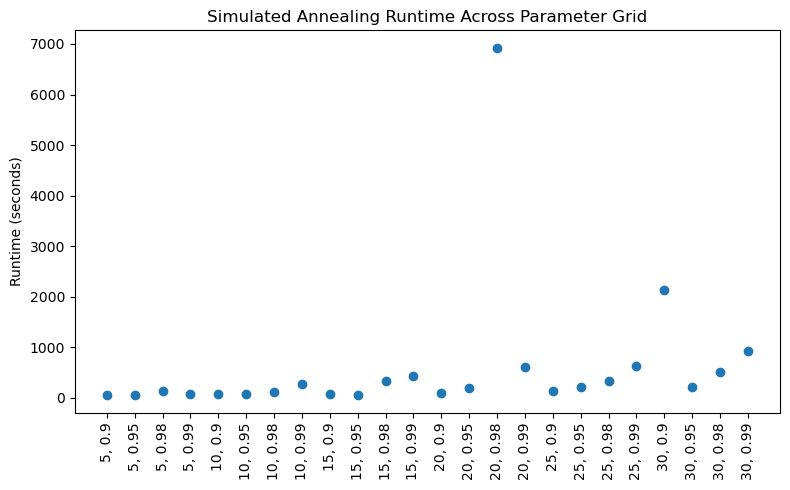

In [43]:
# Plot runtime
plt.figure(figsize=(8,5))
plt.scatter(range(len(df)), df["runtime_sec"])
plt.xticks(range(len(df)), df["T_init"].astype(str) + ", " + df["alpha"].astype(str), rotation=90)
plt.ylabel("Runtime (seconds)")
plt.title("Simulated Annealing Runtime Across Parameter Grid")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Simulated Annealing Runtime Across Parameter Grid, outlier removed')

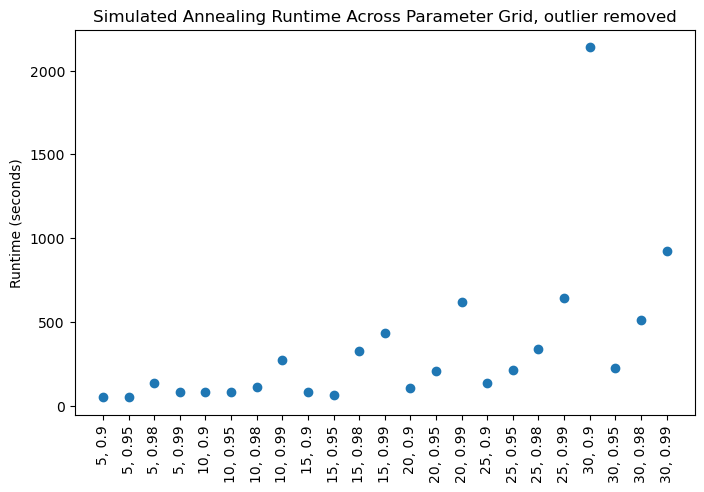

In [44]:
df_clean = df[~((df["T_init"] == 20) & (df["alpha"] == 0.98))]
plt.figure(figsize=(8,5))
plt.scatter(range(len(df_clean)), df_clean["runtime_sec"])
plt.xticks(range(len(df_clean)), df_clean["T_init"].astype(str) + ", " + df_clean["alpha"].astype(str), rotation=90)
plt.ylabel("Runtime (seconds)")
plt.title("Simulated Annealing Runtime Across Parameter Grid, outlier removed")

## Subtask 11: More experiments
The problem is, the instances in the different folders have all widely differnet gamma values, so it does not really make sense to compare them. Let's instead compare the instances for fixed n with varying gamma. So let's chose n = 100 and test our instances for varying gammas. You can easily change the algorithm in the folliwng code to test different alogrithms, I didn't do it in different cells after each other in order not to bloat the notebook.

In [62]:
    folder = f"instances/1000/test" # change folder to test differnt n's
    files = glob.glob(os.path.join(folder, "*.txt"))
    files.sort()
    rows = []

    for file in files:
        instance = Instance(file)
        start_time = time.time()
        solution = randomized_nearest_neighbor_heuristic(instance, 0.5)
        runtime = time.time() - start_time

        rows.append({
            "n": instance.n,
            "gamma": instance.gamma,
            "objective": objective_function(instance, solution),
            "runtime": runtime
        })

    df = pd.DataFrame(rows)
    df.to_csv("results_100.csv", index=False)

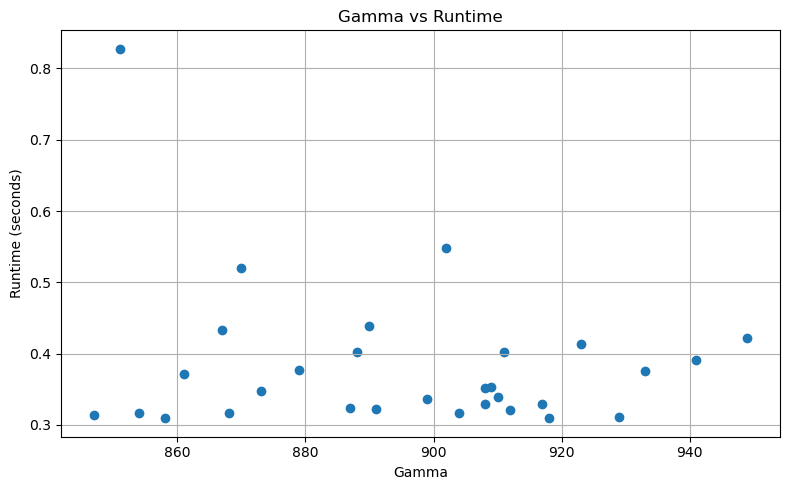

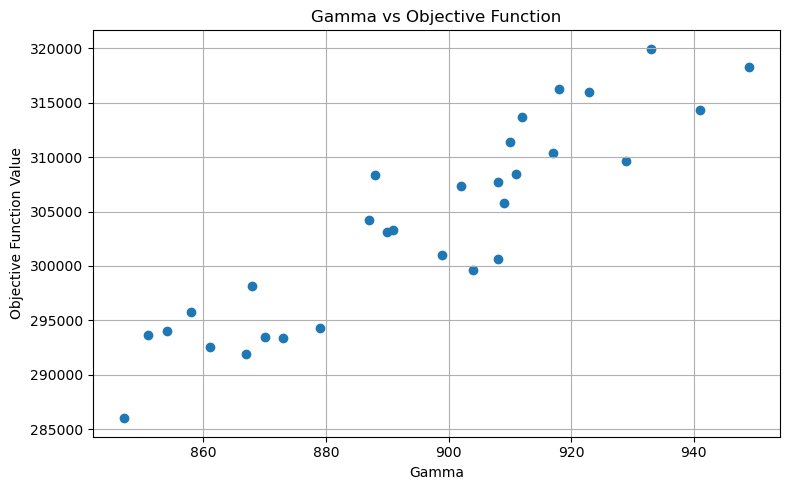

In [63]:
df = pd.read_csv("results_100.csv")

# --- Plot: Gamma vs Runtime ---
plt.figure(figsize=(8, 5))
plt.scatter(df["gamma"], df["runtime"])
plt.xlabel("Gamma")
plt.ylabel("Runtime (seconds)")
plt.title("Gamma vs Runtime")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Gamma vs Objective Function ---
plt.figure(figsize=(8, 5))
plt.scatter(df["gamma"], df["objective"])
plt.xlabel("Gamma")
plt.ylabel("Objective Function Value")
plt.title("Gamma vs Objective Function")
plt.grid(True)
plt.tight_layout()
plt.show()

# Creating the solution files
Now we actually want to create solution files we can submit to tuwel

In [104]:
def save_solution(instance_file_path, routes, output_dir="solutions"):
    """
    Saves the solution in the required format:
    first line = instance file name (without path & extension)
    next lines = each route (only request indices), space-separated
    """

    # ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # extract instance name
    instance_name = os.path.splitext(os.path.basename(instance_file_path))[0]

    # prepare output file path
    out_file = os.path.join(output_dir, instance_name + "_solution.txt")

    with open(out_file, "w") as f:
        # first line: instance name
        f.write(instance_name + "\n")

        # then each vehicle route, request indices separated with spaces
        for route in routes:
            # route is something like [1, 11, 2, 3, 13, ...]
            line = " ".join(str(r) for r in route)
            f.write(line + "\n")

    print(f"Saved solution to {out_file}")

In [105]:
# Lets generate a solution
relevant_files = ["instances/100/competition/instance61_nreq100_nveh2_gamma91.txt",  "instances/1000/competition/instance61_nreq1000_nveh20_gamma879.txt","instances/2000/competition/instance61_nreq2000_nveh40_gamma1829.txt"]
for file in relevant_files:
    instance = Instance(file)
    solution = nearest_neighbor_heuristic(instance)
    #solution = beam_search(instance, 3)
    save_solution(file, solution, "solutions_deterministic_construction_heuristic")

Saved solution to solutions_deterministic_construction_heuristic/instance61_nreq100_nveh2_gamma91_solution.txt
Saved solution to solutions_deterministic_construction_heuristic/instance61_nreq1000_nveh20_gamma879_solution.txt
Saved solution to solutions_deterministic_construction_heuristic/instance61_nreq2000_nveh40_gamma1829_solution.txt
